In [ ]:
# построить спектрограмму сигнала

In [22]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

from IPython.display import Audio

import plotly.graph_objs as go
import plotly.plotly as py
import plotly

%matplotlib inline
plt.rc('figure', figsize=(13, 5))
# init_notebook_mode(connected=True)

In [23]:
plotly.tools.set_credentials_file(username='louis_cauchy', api_key='kL9wATGK2n1LNo0RJFeV')

In [7]:
!ls RAVDESS/speech/Actor_01_cp

angry-normal-01-01-male.wav    fearful-strong-02-01-male.wav
angry-normal-01-02-male.wav    fearful-strong-02-02-male.wav
angry-normal-02-01-male.wav    happy-normal-01-01-male.wav
angry-normal-02-02-male.wav    happy-normal-01-02-male.wav
angry-strong-01-01-male.wav    happy-normal-02-01-male.wav
angry-strong-01-02-male.wav    happy-normal-02-02-male.wav
angry-strong-02-01-male.wav    happy-strong-01-01-male.wav
angry-strong-02-02-male.wav    happy-strong-01-02-male.wav
calm-normal-01-01-male.wav     happy-strong-02-01-male.wav
calm-normal-01-02-male.wav     happy-strong-02-02-male.wav
calm-normal-02-01-male.wav     neutral-normal-01-01-male.wav
calm-normal-02-02-male.wav     neutral-normal-01-02-male.wav
calm-strong-01-01-male.wav     neutral-normal-02-01-male.wav
calm-strong-01-02-male.wav     neutral-normal-02-02-male.wav
calm-strong-02-01-male.wav     sad-normal-01-01-male.wav
calm-strong-02-02-male.wav     sad-normal-01-02-male.wav
disgust-normal-01-01-male.wav  sad-normal-02-01-

In [2]:
path = 'RAVDESS/speech/Actor_01_cp'
file = '/angry-strong-01-01-male.wav'

In [3]:
Audio(path + file)

In [4]:
def convert_wav_to_float(data):
    if data.dtype == np.uint8:
        data = (data - 128) / 128.
    elif data.dtype == np.int16:
        data = data / 32768.
    elif data.dtype == np.int32:
        data = data / 2147483648.
    return data

In [36]:
def gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, dyn_range=120, 
                         cmap=None, ax=None):
    from scipy.signal import spectrogram, gaussian
    from matplotlib.colors import LogNorm
    from matplotlib.cm import get_cmap
    
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8.
    
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    # compute the power spectral density
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    p_ref = 2e-5  # 20 μPa, the standard reference pressure for sound in air

    # set lower bound of colormap (vmin) from dynamic range. The upper bound defaults
    # to the largest value in the spectrogram, so we don't need to set it explicitly.
    dB_max = 10 * np.log10(power.max() / (p_ref ** 2))
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)

    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('viridis')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()

    # other arguments to the figure
    extent = (times.min(), times.max(), freqs.min(), freqs.max())

    # plot
    ax.imshow(power, origin='lower', aspect='auto', cmap=cmap,
              norm=LogNorm(), extent=extent, vmin=vmin, vmax=None)
    return ax


def praat_spectrogram(x, fs, window_dur=0.005, dyn_range=120, ax=None):
    # this function is less flexible than the other (to make it shorter, 
    # since it's just for demo purposes).
    from scipy.signal import spectrogram, gaussian
    from matplotlib.cm import get_cmap
    
    step_dur = window_dur / np.sqrt(np.pi) / 8.
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    noverlap = window_nsamp - step_nsamp
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)
    p_ref = 2e-5
    log_psd = 10 * np.log10(power / (p_ref ** 2))  # key difference
    dB_max = log_psd.max()
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)
    cmap = get_cmap('viridis')
    if ax is None:
        fig, ax = plt.subplots()
    extent = (times.min(), times.max(), freqs.min(), freqs.max())
    # next line: pass `log_psd` instead of `power`; no `LogNorm`
    ax.imshow(log_psd, origin='lower', aspect='auto', cmap=cmap,
              extent=extent, vmin=vmin, vmax=None)
    return ax

In [5]:
sampling_rate, wav_data = scipy.io.wavfile.read(path + file) # int16 data

/home/lovely/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



In [6]:
sampling_rate

48000

In [7]:
wav_data

array([-27, -17, -18, ...,   0,   0,   0], dtype=int16)

In [8]:
wav_data = convert_wav_to_float(wav_data)

In [9]:
wav_data

array([-0.00082397, -0.0005188 , -0.00054932, ...,  0.        ,
        0.        ,  0.        ])

In [10]:
n_samples = len(wav_data)
total_duration = n_samples / sampling_rate
sample_times = np.linspace(0, total_duration, n_samples)

In [11]:
total_duration, n_samples

(4.104104166666667, 196997)

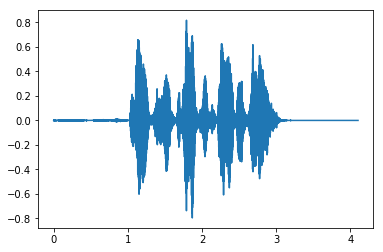

In [14]:
plt.plot(sample_times, wav_data);

In [28]:
trace = go.Scatter(
    x = sample_times[:5000],
    y = wav_data[:5000],
)
py.iplot([trace])

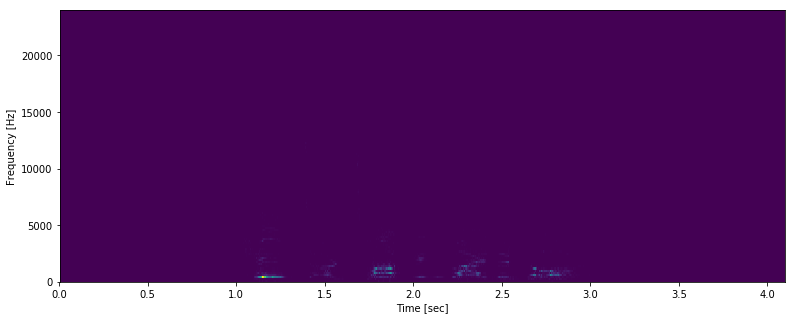

In [31]:
# херня
f, t, Sxx = scipy.signal.spectrogram(wav_data, sampling_rate)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

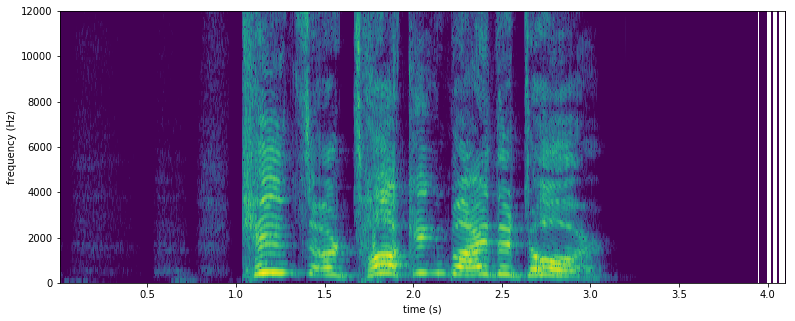

In [35]:
ax = gaussian_spectrogram(wav_data, sampling_rate)
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)');

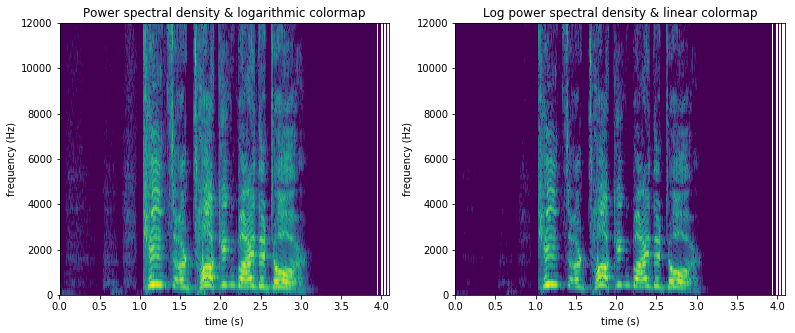

In [38]:
fig, axs = plt.subplots(1, 2)
ax = gaussian_spectrogram(wav_data, sampling_rate, ax=axs[0])
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Power spectral density & logarithmic colormap')
ax = praat_spectrogram(wav_data, sampling_rate, ax=axs[1])
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Log power spectral density & linear colormap');